In [34]:
import sys
import os
import json

sys.path.append(os.path.join(os.getcwd(), ".."))

from Extra.utils import parse_xml, translate_coco_to_images_net, clear_directory, find_xml_file, calculate_iou, get_scores

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision import transforms
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import numpy as np

In [35]:
resources_directory = "../../resources/"

# Load COCO class labels
class_labels = []
with open(resources_directory + "faster_rcnn_coco.names", "rt") as f:
    class_labels = f.read().rstrip('\n').split('\n')

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True, weights='DEFAULT')
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
folder_path = "../../testImagesNet/Data/"
annotations_directory = "../../testImagesNet/Annotations/"
output_directory = "../../output/images/faster_pytorch/"

clear_directory(output_directory)

image_list = []
image_path_list = []

# List all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.png', '.jpeg', '.JPEG')):  # You can add more extensions if needed
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the image and append it to the list
        img = Image.open(file_path)
        image_list.append(img)
        image_path_list.append(file_path)


n = 0
results = {}
for image in image_list:
    # Transform the image and make predictions
    transform = transforms.Compose([transforms.ToTensor()])
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        prediction = model(input_image)

    xml_data = parse_xml(find_xml_file(annotations_directory, image_path_list[n]))

    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels'] - 1
    scores = prediction[0]['scores']

    for target in xml_data:
        iou = 0

        searched_label = translate_coco_to_images_net(target["name"])

        image_iou_dict = {}
        if searched_label in results:
            image_iou_dict = results[searched_label]
        if image_path_list[n] not in image_iou_dict:
            image_iou_dict[image_path_list[n]] = []

        for box, label, score in zip(boxes, labels, scores):
            if (label < len(class_labels) and score.item() > 0.5) :
                box = [round(i, 2) for i in box.tolist()]
                label_name = class_labels[label]
                draw.rectangle(box, outline='red', width=3)
                draw.text((box[0], box[1]), f'{label_name} {round(score.item(), 2)}', fill='white')    

                if (label_name == searched_label):
                    box1 = box
                    box2 = [target["xmin"], target["ymin"], target["xmax"], target["ymax"]]

                    new_iou = calculate_iou(box1, box2)

                    if new_iou > iou:
                        iou = new_iou

        image_iou_dict[image_path_list[n]].append(iou)
        results[searched_label] = image_iou_dict

    # Save the modified image to the output folder
    output_path = os.path.join(output_directory, os.path.basename(image_path_list[n]))
    image.save(output_path)

    n += 1

In [37]:
print(results["dog"])
print(results["car"])
print(results["apple"])

{'../../testImagesNet/Data/n02089973_1.JPEG': [0.6708429179964783], '../../testImagesNet/Data/n02089973_13.JPEG': [0.8447956713655138, 0.9120961893845471], '../../testImagesNet/Data/n02089973_2.JPEG': [0.7882314238190482], '../../testImagesNet/Data/n02089973_26.JPEG': [0.7519916472707834], '../../testImagesNet/Data/n02093859_10.JPEG': [0.906584360672481], '../../testImagesNet/Data/n02093859_3.JPEG': [0.855870495015179], '../../testImagesNet/Data/n02097209_1.JPEG': [0.9420949795079969], '../../testImagesNet/Data/n02097209_12.JPEG': [0.8765719135850979, 0.9179284765388329], '../../testImagesNet/Data/n02097209_8.JPEG': [0.9643429291524059], '../../testImagesNet/Data/n02105855_5.JPEG': [0.8949099359407883], '../../testImagesNet/Data/n02111277_25.JPEG': [0.7632488895671518], '../../testImagesNet/Data/n02112018_2991.JPEG': [0.8824298961167895], '../../testImagesNet/Data/n02112018_3024.JPEG': [0.9058833200338389], '../../testImagesNet/Data/n02112018_3033.JPEG': [0.7430755293050783], '../../te

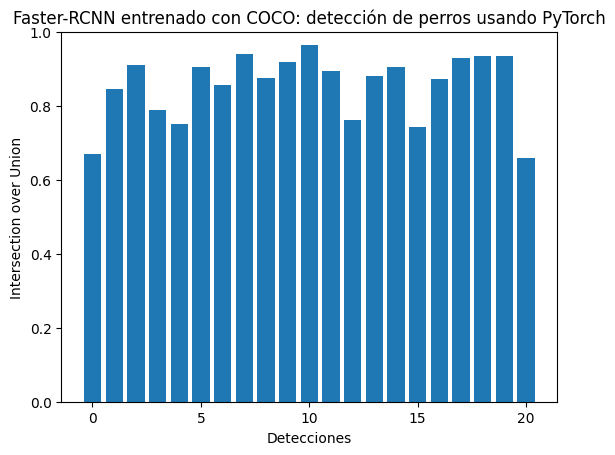

In [38]:
data = results["dog"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('Faster-RCNN entrenado con COCO: detección de perros usando PyTorch')

# Show the plot
plt.show()

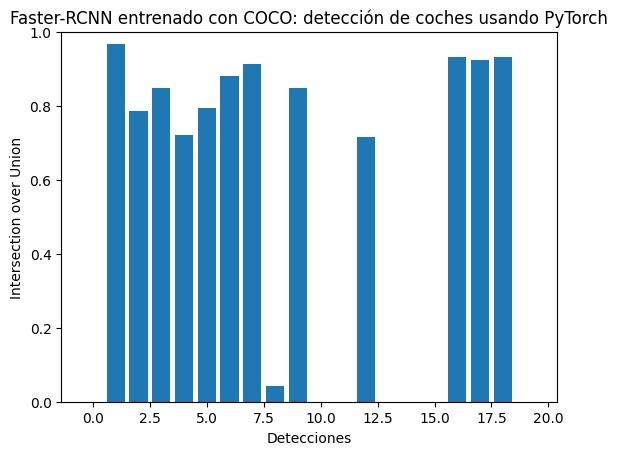

In [39]:
data = results["car"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('Faster-RCNN entrenado con COCO: detección de coches usando PyTorch')

# Show the plot
plt.show()

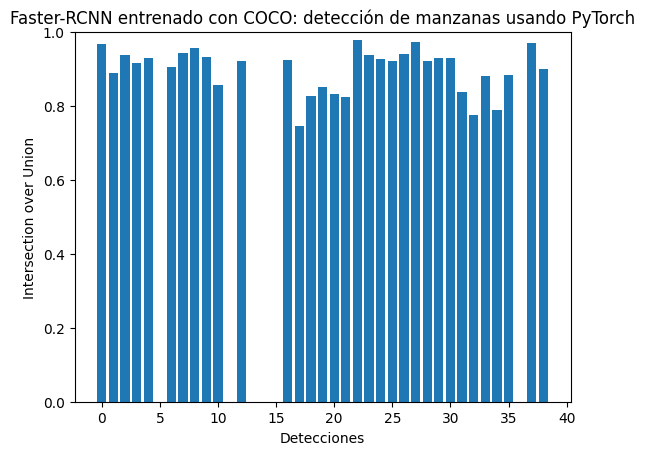

In [40]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

# Create bar chart
plt.bar(range(len(merged_array)), merged_array)

# Set the y-axis limits to ensure the range is between 0 and 1
plt.ylim(0, 1)

# Add labels and title
plt.xlabel('Detecciones')
plt.ylabel('Intersection over Union')
plt.title('Faster-RCNN entrenado con COCO: detección de manzanas usando PyTorch')

# Show the plot
plt.show()

## Métricas de error

In [41]:
threshold = 0.5
# Specify the file path where you want to export the dictionary
score_export_folder_path = "../../output/scores/"

In [42]:
data = results["dog"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

score_export_file_path = "faster_rcnn_dog_pytorch_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.8549457613227689
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MSE: 0.028742727669241734
MAE: 0.14505423867723113
MLSE: 0.008191119179035821


In [43]:
data = results["car"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

score_export_file_path = "faster_rcnn_car_pytorch_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.5158912640063396
Precision: 0.9230769230769231
Recall: 0.631578947368421
F1-score: 0.7499999999999999
MSE: 0.4121065677345291
MAE: 0.4841087359936604
MLSE: 0.19391465777421307


In [44]:
data = results["apple"]

merged_array = np.concatenate(list(data.values()))

scores = get_scores(merged_array, threshold)

print("Average IoU: " + str(scores["average_iou"]))
print("Precision: " + str(scores["precision"]))
print("Recall: " + str(scores["recall"]))
print("F1-score: " + str(scores["f1"]))
print("MSE: " + str(scores["mse"]))
print("MAE: " + str(scores["mae"]))
print("MLSE: " + str(scores["mlse"]))

score_export_file_path = "faster_rcnn_apple_pytorch_scores.json"
# Export the dictionary to a JSON file
with open(score_export_folder_path + score_export_file_path, 'w') as file:
    json.dump(scores, file)

Average IoU: 0.7607511495833389
Precision: 1.0
Recall: 0.8461538461538461
F1-score: 0.9166666666666666
MSE: 0.1654020193568228
MAE: 0.23924885041666114
MLSE: 0.07706711136428504
